In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [5]:
df = pd.read_csv('populationgroup-wise-deposits.csv')

In [6]:
X = df[['no_of_offices','no_of_accounts']]
y = df['deposit_amount']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

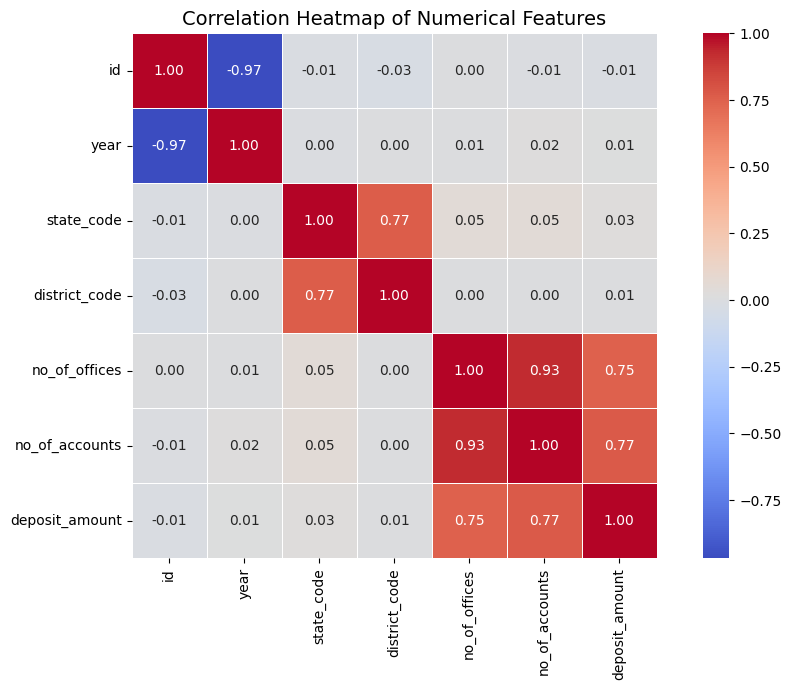

In [8]:
os.makedirs("regression_graphs", exist_ok=True)

corr = df.corr(numeric_only=True)

plt.figure(figsize=(10, 7))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    square=True
)
plt.title("Correlation Heatmap of Numerical Features", fontsize=14)
plt.tight_layout()
plt.savefig("regression_graphs/correlation_heatmap_seaborn.png")
plt.show()

In [9]:
models = {
    "Linear Regression": (LinearRegression(), {}),
    
    "Decision Tree": (
        DecisionTreeRegressor(random_state=42),
        {"max_depth": [2,4,6,8,10,None]}
    ),

    "Random Forest": (
        RandomForestRegressor(random_state=42),
        {"n_estimators": [50,100,200],
         "max_depth": [4,6,8,None]}
    ),
    
    "SVR": (
        SVR(),
        {"kernel": ["linear", "rbf"],
         "C": [0.1, 1, 10]}
    ),

    "KNN Regressor": (
        KNeighborsRegressor(),
        {"n_neighbors": [3,5,7,9]}
    )
}

In [27]:
results = {
    "Model": [],
    "R2 Score": [],
    "MAE": [],
    "MSE": [],
    "CrossVal_R2": []
}

In [28]:
def run_model(name, model, params={}):
    print(f"MODEL : {name}")

    # -----------------------------
    # Hyperparameter Tuning
    # -----------------------------
    if params:
        print("→ Running GridSearchCV...")
        grid = GridSearchCV(model, params, cv=5, scoring="r2", n_jobs=-1)
        grid.fit(X_train, y_train)
        model = grid.best_estimator_
        print(f"   Best Params: {grid.best_params_}")
    else:
        model.fit(X_train, y_train)

    # -----------------------------
    # Predictions
    # -----------------------------
    preds = model.predict(X_test)

    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    cv_score = cross_val_score(model, X, y, cv=5, scoring="r2").mean()

    # Save results
    results["Model"].append(name)
    results["R2 Score"].append(r2)
    results["MAE"].append(mae)
    results["MSE"].append(mse)
    results["CrossVal_R2"].append(cv_score)

    # -----------------------------
    # Print metrics
    # -----------------------------
    print(f"R² Score       : {r2:.4f}")
    print(f"MAE            : {mae:.4f}")
    print(f"MSE            : {mse:.4f}")
    print(f"CrossVal (R²)  : {cv_score:.4f}")

    # -----------------------------
    # Plot Actual vs Predicted
    # -----------------------------
    plt.figure(figsize=(6,4))
    plt.scatter(y_test, preds)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{name} - Actual vs Predicted")
    plt.tight_layout()
    plt.savefig(f"regression_graphs/{name.replace(' ','_')}.png")
    plt.show()

MODEL : Linear Regression
R² Score       : 0.6777
MAE            : 8175.8557
MSE            : 466206036.7754
CrossVal (R²)  : 0.6053


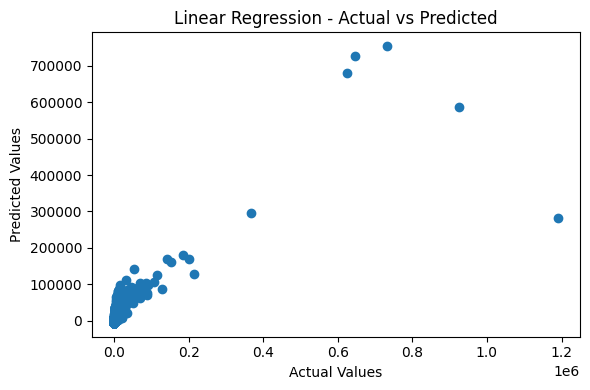

In [29]:
run_model("Linear Regression", LinearRegression())

MODEL : Decision Tree
→ Running GridSearchCV...
   Best Params: {'max_depth': 6}
R² Score       : 0.9408
MAE            : 1573.5160
MSE            : 85644238.0440
CrossVal (R²)  : 0.8697


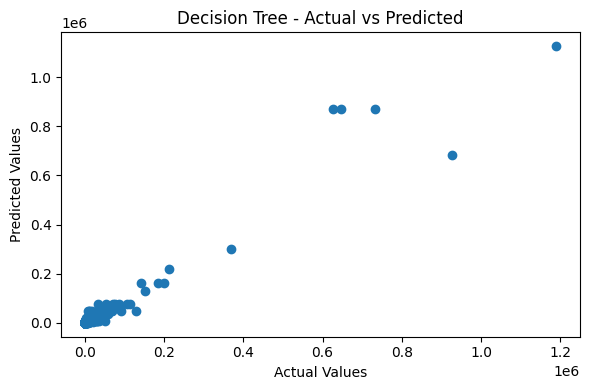

In [30]:
run_model("Decision Tree", DecisionTreeRegressor(random_state=42), {"max_depth": [2,4,6,8,10,None]})

MODEL : Random Forest
→ Running GridSearchCV...
   Best Params: {'max_depth': 6, 'n_estimators': 200}
R² Score       : 0.9349
MAE            : 1595.8140
MSE            : 94194508.4215
CrossVal (R²)  : 0.8764


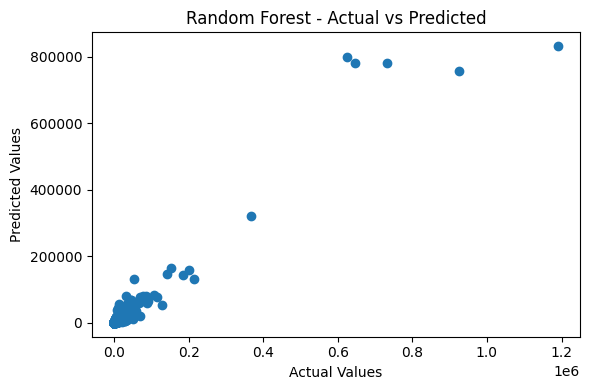

In [31]:
run_model("Random Forest", RandomForestRegressor(random_state=42), {"n_estimators": [50,100,200], "max_depth": [4,6,8,None]})

MODEL : KNN Regressor
→ Running GridSearchCV...
   Best Params: {'n_neighbors': 5}
R² Score       : 0.8733
MAE            : 1916.2846
MSE            : 183310996.3397
CrossVal (R²)  : 0.7677


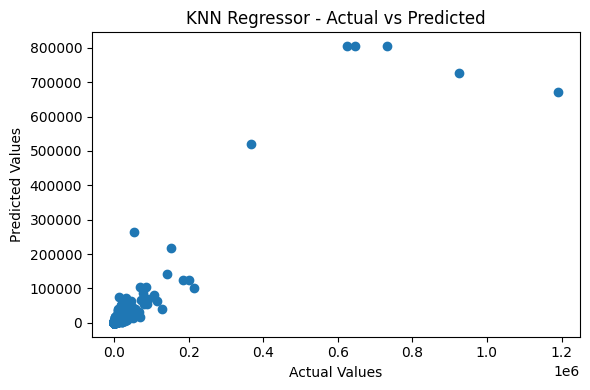

In [32]:
run_model("KNN Regressor", KNeighborsRegressor(), {"n_neighbors": [3,5,7,9]})

In [33]:
results_df = pd.DataFrame(results)

print("FINAL MODEL COMPARISON TABLE\n")
print(results_df)

FINAL MODEL COMPARISON TABLE

               Model  R2 Score          MAE           MSE  CrossVal_R2
0  Linear Regression  0.677722  8175.855713  4.662060e+08     0.605279
1      Decision Tree  0.940796  1573.515960  8.564424e+07     0.869743
2      Random Forest  0.934885  1595.814018  9.419451e+07     0.876360
3      KNN Regressor  0.873281  1916.284615  1.833110e+08     0.767660


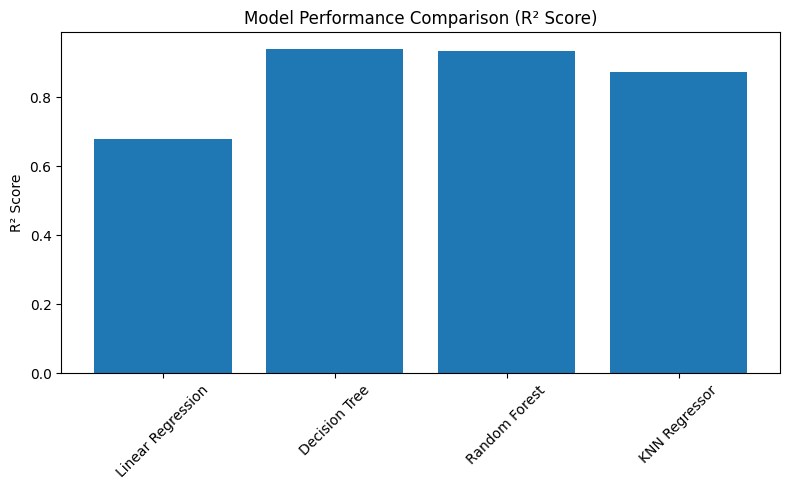

In [34]:
plt.figure(figsize=(8,5))
plt.bar(results_df["Model"], results_df["R2 Score"])
plt.ylabel("R² Score")
plt.title("Model Performance Comparison (R² Score)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("regression_graphs/final_comparison_r2.png")
plt.show()
